In [5]:
# First we need to mount the Google drive 
import os
from google.colab import drive
drive.mount('/content/gdrive')
# Here specify the path to your directory
!ls "/content/gdrive/My Drive/ResNet_CIFAR10_TF" 
root_path = 'gdrive/My Drive/ResNet_CIFAR10_TF' 
path = '/content/gdrive/My Drive/ResNet_CIFAR10_TF'
os.chdir(path)

Mounted at /content/gdrive
ResNet20v1e200.png    ResNext29_2x64de200.png  tf_resnext_cifar10.ipynb
ResNet20v1e50.png     ResNext29_2x64d.png
ResNet_CIFAR10.ipynb  saved_models


In [1]:
%load_ext tensorboard

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input
from tensorflow.keras.layers import Flatten, add
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
import math
import csv
import tensorflow.keras.backend as K
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone

# training parameters
batch_size = 128 # 32 # orig paper trained all networks with batch_size=128
weight_decay = 0.0005
momentum = 0.9
learning_rate = 0.1
reducing_lr = 0.1
epochs = 300
data_augmentation = True
num_classes = 10

# network settings
depth = 29
cardinality = 2
width = 64

# subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# model name, depth and version
model_type = 'ResNext%d_%dx%dd' % (depth, cardinality, width)
print("Model type: ", model_type)

# load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# input image dimensions.
input_shape = x_train.shape[1:]

# normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# if subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)


def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    # lr = 1e-3
    lr = learning_rate
    # if epoch > 180:
    #     lr *= 0.5e-3
    # elif epoch > 160:
    #     lr *= 1e-3
    # elif epoch > 120:
    #     lr *= 1e-2
    # elif epoch > 80:
    #     lr *= 1e-1
    if epoch >= 225:
      lr *= (reducing_lr * reducing_lr)
    elif epoch >= 150:
      lr *= reducing_lr
    print('Learning rate: ', lr)
    return lr

Model type:  ResNext29_2x64d
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [3]:
def resnet_layer(inputs,
                 num_filters=64,
                 kernel_size=3,
                 strides=1,
                 groups=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    Arguments:
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        groups (int): the number of groups (cardinality)
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    Returns:
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  groups=groups,
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(weight_decay)) # 1e-4 

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnext29(input_shape, channels, groups, base_width): # 2x64d (groups: 2, base_width: 64)
    expansion = 4
    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)

    for stage in range(3):
        width = int(math.floor(channels * (base_width / 64.0)) * groups)
        for res_block in range(3):
            strides = 1
            # first layer but not first stage
            if stage > 0 and res_block == 0:
                strides = 2  # downsample
            # Conv 1x1, BN, ReLU
            y = resnet_layer(inputs=x,
                             num_filters=width, # num_filters
                             kernel_size=1,
                             strides=strides,
                             groups=1) # groups=groups
            # Conv 3x3, BN, ReLU
            y = resnet_layer(inputs=y,
                             num_filters=width, # num_filters
                             kernel_size=3,
                             groups=groups)
            # Conv 1x1, BN
            y = resnet_layer(inputs=y,
                             num_filters=channels * expansion, 
                             kernel_size=1,
                             groups=1, # groups=groups
                             activation=None,
                             batch_normalization=True)
            # downsampling for shortcut
            if res_block == 0:
                # linear projection residual shortcut
                # connection to match changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=channels * expansion, 
                                 kernel_size=1,
                                 groups=1, # groups=groups
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=True)
            x = add([x, y])
            x = Activation('relu')(x)
        channels *= 2

    # add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [4]:
model = resnext29(input_shape=input_shape, channels=64, groups=cardinality, base_width=width)
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=learning_rate, momentum=momentum), # Adam(lr=lr_schedule(0))  
              metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


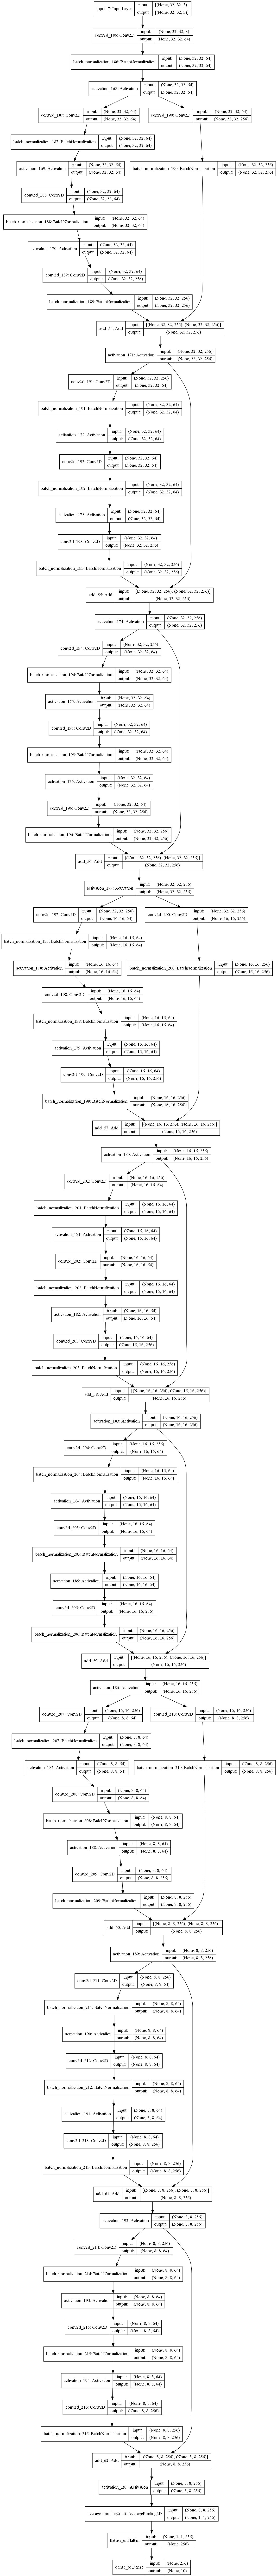

In [22]:
# enable this if pydot can be installed
# pip install pydot
plot_model(model, to_file="%s.png" % model_type, show_shapes=True)

In [5]:
model_name = model_type + f'_e{epochs}'
print('model_name:', model_name)

# prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
print('save_dir: ', save_dir)

# model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
model_save_name = 'cifar10_%s.h5' % model_name
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_directory = os.path.join(save_dir, model_name)
print('model_directory:', model_directory)

if not os.path.isdir(model_directory):
    os.makedirs(model_directory)

filepath = os.path.join(model_directory, model_save_name)
print('filepath:', filepath)

logdir = os.path.join(model_directory, "logs", datetime.datetime.now(timezone('Asia/Seoul')).strftime("%Y%m%d-%H%M%S"))
print('logdir:', logdir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(monitor='val_acc',
                               factor=0.1, # np.sqrt(0.1)
                               patience=5, # 10
                               verbose=1,
                               mode='max',
                               cooldown=0,
                               min_lr=0.5e-6)

model_name: ResNext29_2x64d_e300
save_dir:  /tokim/code/networks/resnet/saved_models
model_directory: /tokim/code/networks/resnet/saved_models/ResNext29_2x64d_e300
filepath: /tokim/code/networks/resnet/saved_models/ResNext29_2x64d_e300/cifar10_ResNext29_2x64d_e300.h5
logdir: /tokim/code/networks/resnet/saved_models/ResNext29_2x64d_e300/logs/20210705-173909


In [6]:
class StoreModelHistory(keras.callbacks.Callback):

  def on_epoch_end(self, batch, logs=None):
    if ('lr' not in logs.keys()):
      logs.setdefault('lr', 0)
      logs['lr'] = K.get_value(self.model.optimizer.lr)

    if not ('model_history.csv' in os.listdir(model_directory)):
      with open(model_directory + '/model_history.csv', 'a') as f:
        y = csv.DictWriter(f, logs.keys())
        y.writeheader()

    with open(model_directory + '/model_history.csv', 'a') as f:
      y = csv.DictWriter(f, logs.keys())
      y.writerow(logs)

In [7]:
callbacks = [StoreModelHistory(), checkpoint, lr_scheduler, tensorboard_callback] # , lr_reducer

In [ ]:
with tf.device('/device:GPU:1'):
    # run training, with or without data augmentation.
    if not data_augmentation:
        print('Not using data augmentation.')
        model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(x_test, y_test),
                  shuffle=True,
                  callbacks=callbacks)
    else:
        print('Using real-time data augmentation.')
        # this will do preprocessing and realtime data augmentation:
        datagen = ImageDataGenerator(
            # set input mean to 0 over the dataset
            featurewise_center=False,
            # set each sample mean to 0
            samplewise_center=False,
            # divide inputs by std of dataset
            featurewise_std_normalization=False,
            # divide each input by its std
            samplewise_std_normalization=False,
            # apply ZCA whitening
            zca_whitening=False,
            # randomly rotate images in the range (deg 0 to 180)
            rotation_range=0,
            # randomly shift images horizontally
            width_shift_range=0.1,
            # randomly shift images vertically
            height_shift_range=0.1,
            # randomly flip images
            horizontal_flip=True,
            # randomly flip images
            vertical_flip=False)

        # compute quantities required for featurewise normalization
        # (std, mean, and principal components if ZCA whitening is applied).
        datagen.fit(x_train)

        steps_per_epoch =  math.ceil(len(x_train) / batch_size)
        # fit the model on the batches generated by datagen.flow().
        model.fit(x=datagen.flow(x_train, y_train, batch_size=batch_size),
                  verbose=1,
                  epochs=epochs,
                  validation_data=(x_test, y_test),
                  steps_per_epoch=steps_per_epoch,
                  callbacks=callbacks)


# score trained model
scores = model.evaluate(x_test,
                        y_test,
                        batch_size=batch_size,
                        verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Using real-time data augmentation.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/300
Learning rate:  0.1
391/391 [==============================] - 93s 223ms/step - loss: 14.8206 - acc: 0.2134 - val_loss: 10.2302 - val_acc: 0.2211

Epoch 00001: val_acc improved from -inf to 0.22110, saving model to /tokim/code/networks/resnet/saved_models/ResNext29_2x64d_e300/cifar10_ResNext29_2x64d_e300.h5
Epoch 2/300
Learning rate:  0.1
391/391 [==============================] - 84s 215ms/step - loss: 7.4224 - acc: 0.3440 - val_loss: 5.6000 - val_acc: 0.3090

Epoch 00002: val_acc improved from 0.22110 to 0.30900, saving model to /tokim/code/networks/resnet/saved_models/ResNext29_2x64d_e300/cifar10_ResNext29_2x64d_e300.h5
Epoch 3/300
Learning rate:  0.1
391/391 [==============================] - 84s 215ms/step - loss: 4.1419 - acc: 0.4492 - val_loss: 3.3589 - val_acc: 0.4323

Epoch 00003: val_acc improved from 0.30900 to 0.43230, saving model to /tokim/code/networks/resnet/saved_models/ResNext29_2x64d_e300/cifar10_ResNext29_2x64d_e300.h5
Epoch 4/300
Learning rate:  0.1
391

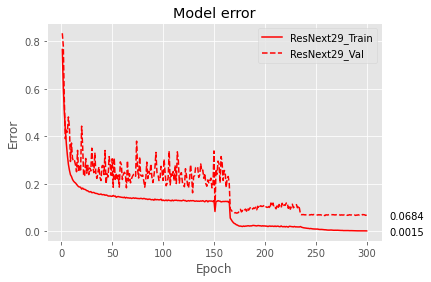

In [16]:
# Plot data
EPOCH = 300 # number of epochs the model has trained for

# ex_history_df = pd.read_csv('/content/gdrive/My Drive/ResNet_CIFAR10_TF/saved_models/ResNext29_2x64de100' + 
#                             '/model_history.csv', sep=',')
history_df = pd.read_csv('/content/gdrive/My Drive/ResNet_CIFAR10_TF/saved_models/ResNext29_2x64d_e300' + 
                         '/model_history.csv', sep=',') # model_directory

# Plot training & validation error values
plt.style.use("ggplot")
# plt.plot(range(1, EPOCH + 1),
#          1 - ex_history_df['acc'], 'b')
# plt.plot(range(1, EPOCH + 1),
#          1 - ex_history_df['val_acc'], 'b', 
#          linestyle='--')
plt.plot(range(1, EPOCH + 1),
         1 - history_df['acc'][:300], 'r')
plt.plot(range(1, EPOCH + 1),
         1 - history_df['val_acc'][:300], 'r', 
         linestyle='--')
plt.title('Model error')
plt.ylabel('Error')
plt.xlabel('Epoch')
legend_1 = plt.legend(['ResNext29_Train', 'ResNext29_Val'], loc='upper right')
plt.annotate('%.4f' % float(1 - history_df['val_acc'][299]), xy=(1, float(1 - history_df['val_acc'][-1:])), xytext=(8, -4), 
              xycoords=('axes fraction', 'data'), textcoords='offset points')
plt.annotate('%.4f' % float(1 - history_df['acc'][299]), xy=(1, float(1 - history_df['acc'][-1:])), xytext=(8, -4), 
              xycoords=('axes fraction', 'data'), textcoords='offset points')
# plt.annotate('%.4f' % float(1 - ex_history_df['val_acc'][-1:]), xy=(1, float(1 - ex_history_df['val_acc'][-1:])), xytext=(8, 6), 
#               xycoords=('axes fraction', 'data'), textcoords='offset points')
plt.show()

In [8]:
loaded_model = tf.keras.models.load_model(filepath)
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:
# update the learning rate
print("[INFO] old learning rate: {}".format(
    K.get_value(loaded_model.optimizer.lr)))

[INFO] old learning rate: 0.0010000000474974513


In [10]:
epochs = 50 # 75

# run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    loaded_model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # this will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False)

    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    steps_per_epoch =  math.ceil(len(x_train) / batch_size)
    # fit the model on the batches generated by datagen.flow().
    loaded_model.fit(x=datagen.flow(x_train, y_train, batch_size=batch_size),
              verbose=1,
              epochs=epochs,
              validation_data=(x_test, y_test),
              steps_per_epoch=steps_per_epoch,
              callbacks=callbacks)

Using real-time data augmentation.
Epoch 1/50
Learning rate:  0.001
391/391 [==============================] - 210s 444ms/step - loss: 0.2534 - acc: 0.9940 - val_loss: 0.4822 - val_acc: 0.9307

Epoch 00001: val_acc improved from -inf to 0.93070, saving model to /content/gdrive/My Drive/ResNet_CIFAR10_TF/saved_models/ResNext29_2x64d_e300/cifar10_ResNext29_2x64d_e300.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
Learning rate:  0.001
391/391 [==============================] - 174s 445ms/step - loss: 0.2503 - acc: 0.9948 - val_loss: 0.4819 - val_acc: 0.9314

Epoch 00002: val_acc improved from 0.93070 to 0.93140, saving model to /content/gdrive/My Drive/ResNet_CIFAR10_TF/saved_models/ResNext29_2x64d_e300/cifar10_ResNext29_2x64d_e300.h5
Epoch 3/50
Learning rate:  0.001
391/391 [==============================] - 175s 447ms/step - loss: 0.2480 - acc: 0.9951 - val_loss: 0.4829 - val_acc: 0.9314

Epoch 00003: val_acc did not improve from 0.93140
Epoch 4/50
Learning rate:  0.001
391/391 [==============================] - 174s 445ms/step - loss: 0.2454 - acc: 0.9953 - val_loss: 0.4840 - val_acc: 0.9297

Epoch 00004: val_acc did not improve from 0.93140
Epoch 5/50
Learning rate:  0.001
391/391 [==============================] - 174s 445ms/step - loss: 0.2433 - acc: 0.9950 - val_loss: 0.4857 - val_acc: 0.9296

Epoch 00005: val_acc did not improve from 0.93140
Epoch 6/50
Learning rate:  0.001
3